In [147]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import EngFormatter
import scipy.signal as sp
formatter0 = EngFormatter(unit='Hz')
rc('font',family='serif')
plt.rcParams['figure.figsize'] = (6,3)
plt.rcParams['figure.dpi'] = 150
file = open("data.bin", "r")
interleaved_data = np.fromfile(file, np.uint8)
file.close()
I_data_raw = interleaved_data[0:len(interleaved_data):2]
Q_data_raw = interleaved_data[1:len(interleaved_data):2]

I_samples = (I_data_raw-127.5)/127.5
Q_samples = (Q_data_raw-127.5)/127.5

complex_data = I_samples + 1j*Q_samples

In [148]:
fs = 2.4E6 #Carrier frequency of SDR
dt = 1/(fs) #Timestep between samples 
symbol_r = 100E3 #Symbol rate 

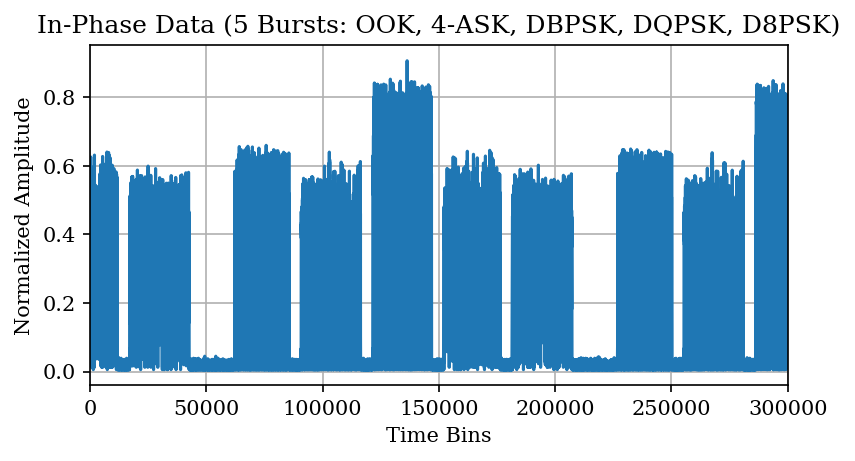

In [149]:
plt.figure(1)
plt.plot(np.abs(complex_data))
plt.xlabel("Time Bins")
plt.ylabel("Normalized Amplitude")
plt.xlim(0,len(I_samples))
#plt.xaxis.set_major_formatter(formatter0)
plt.title("In-Phase Data (5 Bursts: OOK, 4-ASK, DBPSK, DQPSK, D8PSK)")
plt.grid()
plt.show()

In [150]:
DBPSK_start = 121590
DBPSK_end = 146800

In [151]:
#Splicing of the data
DBPSK_I = I_samples[DBPSK_start:DBPSK_end]
DBPSK_Q = Q_samples[DBPSK_start:DBPSK_end]
DBPSK_mag = np.abs(complex_data)[DBPSK_start:DBPSK_end]

In [152]:
#Normalizing the data
DBPSK_I = DBPSK_I / DBPSK_mag.max()
DBPSK_Q = DBPSK_Q / DBPSK_mag.max()

DBPSK_signal = DBPSK_I + 1j*DBPSK_Q

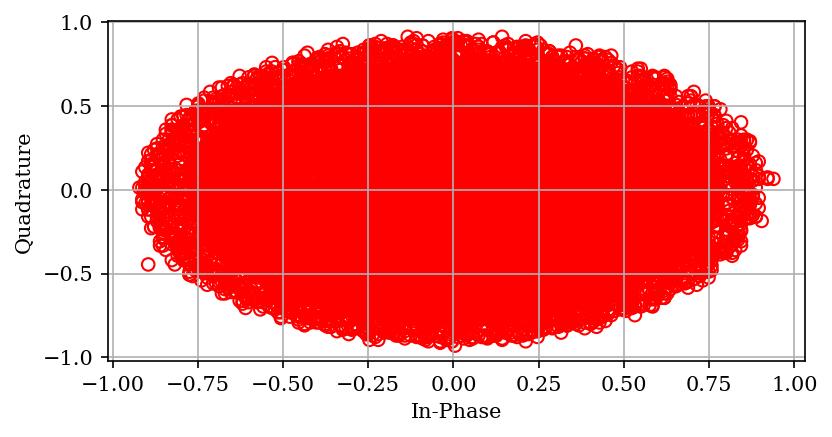

In [153]:
#Scatter Plot of the DBPSK data.
f1, ax1 = plt.subplots(1,1)
#ax1.xaxis.set_major_formatter(formatter0)
ax1.scatter(np.real(DBPSK_signal), np.imag(DBPSK_signal),facecolors='none', edgecolors='r') 
plt.xlabel("In-Phase") 
plt.ylabel("Quadrature")
plt.grid()
plt.show()

In [154]:
#create a time array
freq = np.fft.fftfreq(len(DBPSK_signal),dt)
bins=np.arange(0,len(DBPSK_signal),1)
t=bins*dt

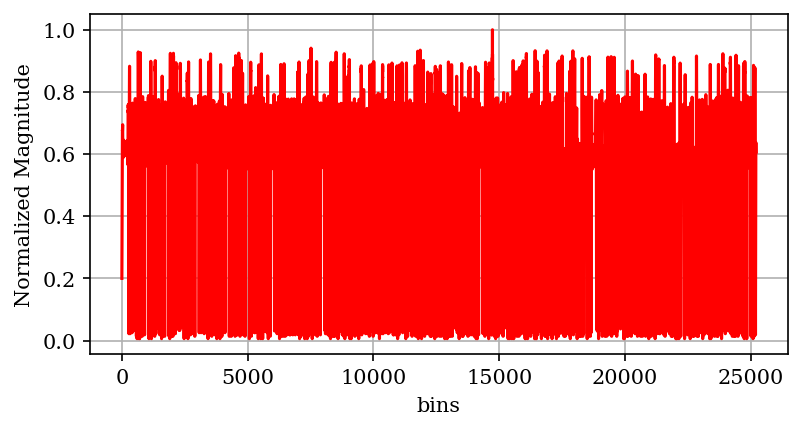

In [155]:
f2, ax2 = plt.subplots(1,1)
#ax2.xaxis.set_major_formatter(formatter0)
ax2.plot(bins,np.abs(DBPSK_signal),'r')
plt.xlabel("bins") 
plt.ylabel("Normalized Magnitude")
plt.grid()
plt.show()

 Corse Frequency Offset: -94752.32925259112 Hz


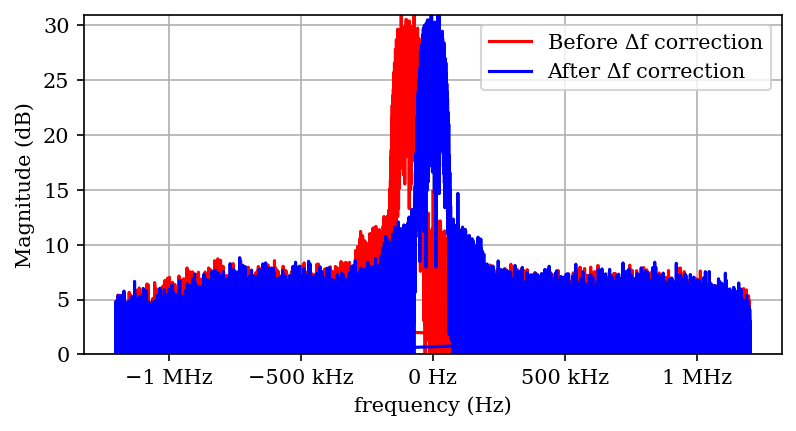

In [156]:
#FFT before corse frequency correction 
DBPSK_SIGNAL_O = np.fft.fft(DBPSK_signal)
DBPSK_MAG_O = 10*np.log10(np.abs(DBPSK_SIGNAL_O))


Δ_Φ = np.diff(np.unwrap((np.angle(DBPSK_signal[2:227]))))
Δ_f = np.median(Δ_Φ)  / (np.pi*2*dt)  
print(" Corse Frequency Offset:",Δ_f,'Hz')

#FFT after corse frequency correction
DBPSK_signal = DBPSK_signal*(np.cos(2*np.pi*(-1*Δ_f)*t) + 1j*np.sin(2*np.pi*(-1*Δ_f)*t))

DBPSK_SIGNAL = np.fft.fft(DBPSK_signal)
DBPSK_MAG = 10*np.log10(np.abs(DBPSK_SIGNAL))

#Plotting the results

f3, ax3 = plt.subplots(1,1)
ax3.xaxis.set_major_formatter(formatter0)
ax3.plot(freq,DBPSK_MAG_O,'r',label='Before Δf correction')
ax3.plot(freq,DBPSK_MAG,'b',label='After Δf correction')
plt.xlabel("frequency (Hz)") 
plt.ylabel("Magnitude (dB)")
plt.legend(loc='upper right')
plt.ylim(0,DBPSK_MAG_O.max())
plt.grid()
plt.show()

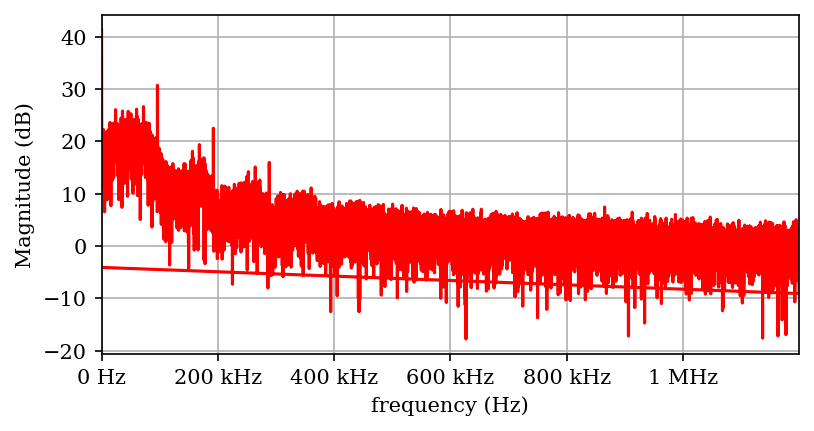

In [157]:
#DFT of |DBPSK_signal|
DBPSK_SIGNAL_ABS = np.fft.fft(np.abs(DBPSK_signal))
DBPSK_MAG_ABS = 10*np.log10(np.abs(DBPSK_SIGNAL_ABS))
DBPSK_SIGNAL_Φ = np.angle(DBPSK_SIGNAL_ABS)

f4, ax4 = plt.subplots(1,1)
ax4.xaxis.set_major_formatter(formatter0)
ax4.plot(freq,DBPSK_MAG_ABS,'r')
plt.xlabel("frequency (Hz)") 
plt.ylabel("Magnitude (dB)")
plt.xlim(0,freq.max())
plt.grid()
plt.show()

In [158]:
#Thus we obtain the frequency of the clock by lDBPSKing for the largest spike above the noise.
Index_max = 800+(DBPSK_MAG_ABS[800:1200].argmax())
f_clk=freq[Index_max]
freq_δ = np.abs(freq[0]-freq[1])/2
#Now need to obtain the phase of the clock.
# I did this by using the index function which searches the array and returns the bin where that value is located
for i, j in enumerate(freq):
    if (f_clk-freq_δ) < j < (f_clk+freq_δ):
            freq_bin=(i)
f_clk = freq[freq_bin]
Φ =DBPSK_SIGNAL_Φ[freq_bin]
print('Clock Frequency:',f_clk,'Hz')
print('Φ:',Φ,'radians')
print('bin:',freq_bin)

Clock Frequency: 96152.32050773503 Hz
Φ: 1.7776543035877206 radians
bin: 1010


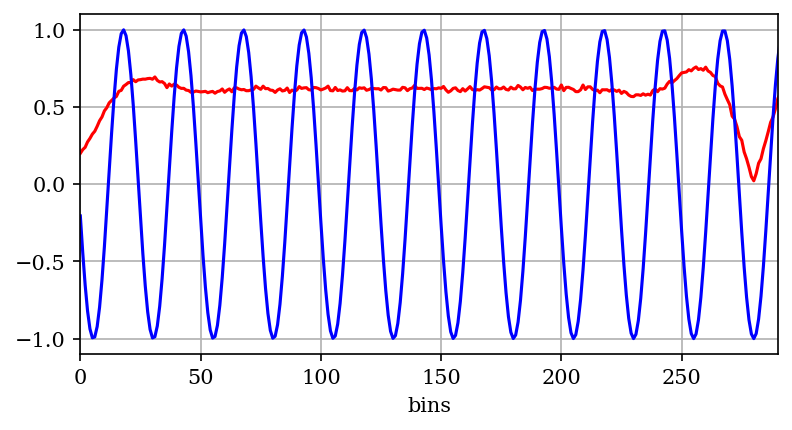

In [159]:
# Define the clock signal
Φ = DBPSK_SIGNAL_Φ[freq_bin]
f = freq[freq_bin]
ω = 2 * np.pi * f
NCO = np.exp(1j*(ω*t + Φ))
f5, ax5 = plt.subplots(1,1)
#ax4.xaxis.set_major_formatter(formatter0)
ax5.plot(bins,np.abs(DBPSK_signal),'r')
ax5.plot(bins,np.real(NCO),'b')
plt.xlabel("bins") 
plt.ylabel("")
plt.xlim(0,290)
plt.grid()
plt.show()

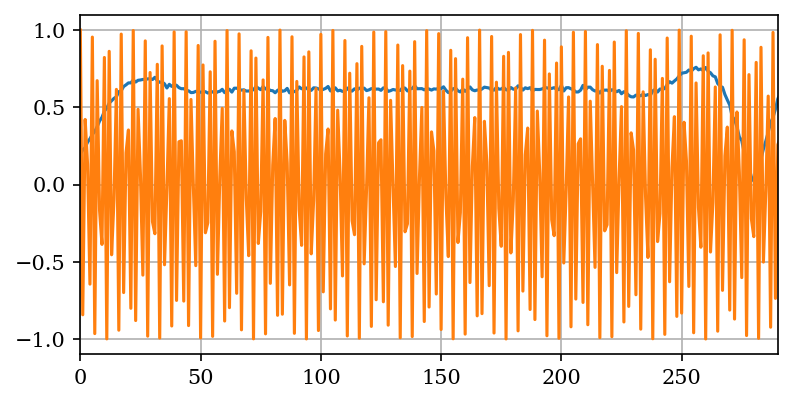

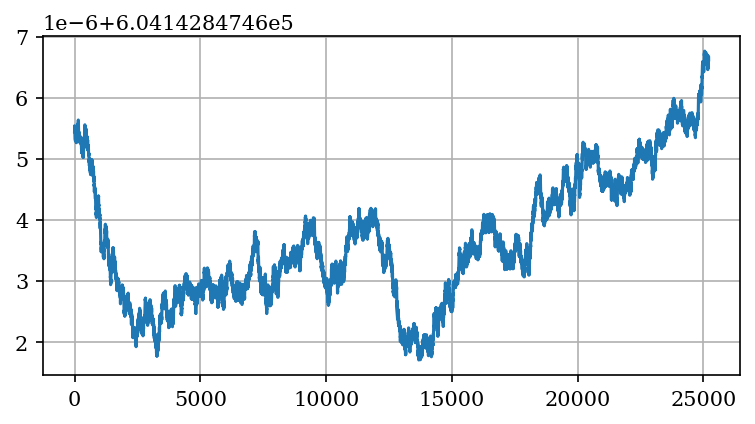

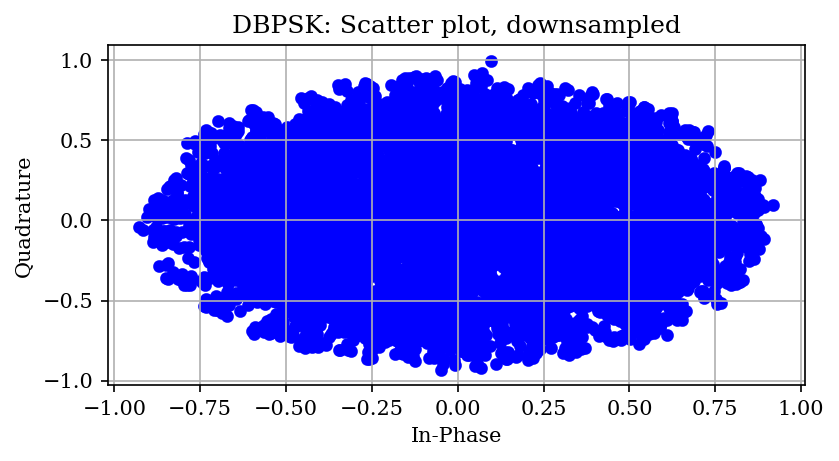

In [217]:
Φ = DBPSK_SIGNAL_Φ[freq_bin]
f = freq[freq_bin]
ω = 2 * np.pi * f
NCO = NCO = np.cos((ω*t)+Φ) + 1j*np.sin((ω*t)+Φ)

bandwidth = 0.02
β = np.sqrt(bandwidth)

freq_out = ω
ϕ_out = DBPSK_SIGNAL_Φ[freq_bin] * ω


Error = []
length = len(bins)
for i in range(length):
    ΔΦ = np.angle(DBPSK_signal[i]*np.conj(NCO[i]))
    freq_out += bandwidth * (ΔΦ/2*np.pi*dt)
    ϕ_out += β * ΔΦ * freq_out
    NCO = np.cos(ϕ_out*t) + 1j*np.sin(ϕ_out*t)
    Error.append(freq_out)
symbol_data = []
peak_bins = sp.find_peaks(np.real(NCO))
for k in peak_bins[0]:
        symbol_data.append(DBPSK_signal[k])
        
plt.figure(6)
plt.plot(bins,np.abs(DBPSK_signal))
plt.plot(bins,np.real(NCO))
plt.xlim(0,290)
plt.grid()
plt.show()
                 
plt.figure(7)
plt.plot(np.unwrap(Error))
plt.grid()
plt.show()

plt.figure(8)
plt.scatter(np.real(symbol_data), np.imag(symbol_data),linewidths=0.1,facecolors='b', edgecolors='b')
plt.xlabel("In-Phase") 
plt.ylabel("Quadrature")
plt.title("DBPSK: Scatter plot, downsampled")
plt.grid()
plt.show()

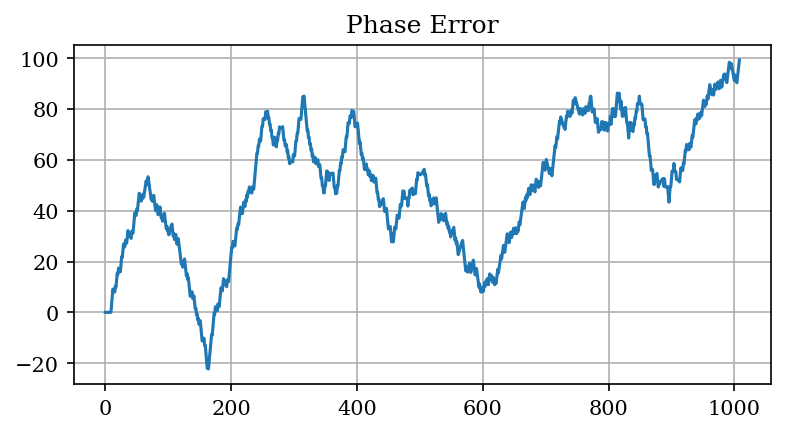

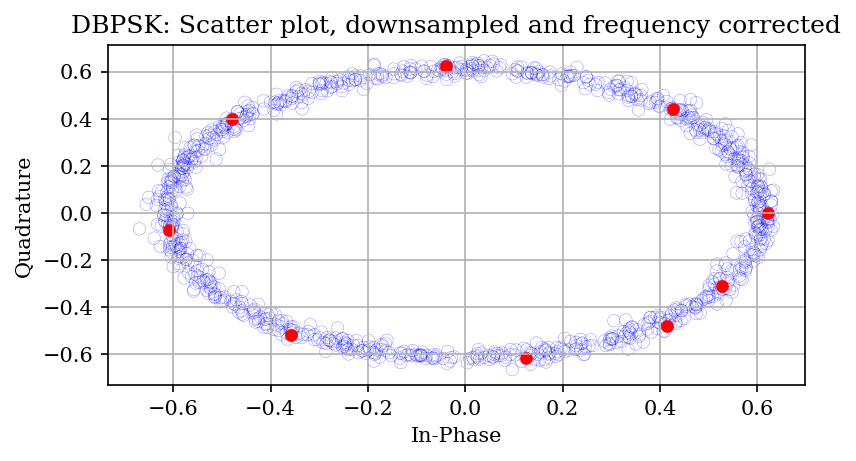

In [146]:
#PLL Variable assignment
fs = 2.4E6 #Carrier frequency of SDR
dt = 1/(fs) #Timestep between samples
#dt = 1/10E3
symbol_data1 = symbol_data
symbol_data2 = symbol_data1
f = 10E3

α = 0.05*f
β = 0.5*(α**2)


length = len(symbol_data)-1
diff=[]
bins=np.arange(0,len(symbol_data),1)
t=bins*dt
ω = 0
Φ = 0
ϕ_out = 0
f_out = 0
for i in range(length):
    ΔΦ = np.angle(symbol_data1[i+1]*np.conj(symbol_data1[i]))
    ϕ_out += α * ΔΦ
    f_out += β * ΔΦ 
    ϕ_out += f_out
    diff.append(ΔΦ)
    symbol_data1 = symbol_data1 *np.e**(-1j*(f_out*t))
symbol_data1 = symbol_data1 * np.e**(-1j*np.angle(symbol_data1[1]))


plt.figure(7)
plt.title("Phase Error")
plt.plot(np.unwrap(diff))
plt.grid()
plt.show()    
    
    

plt.figure(8)
plt.scatter(np.real(symbol_data1), np.imag(symbol_data1),linewidths=0.1,facecolors='none', edgecolors='b')
plt.scatter(np.real(symbol_data1[0:9]), np.imag(symbol_data1[0:9]),linewidths=0.1,facecolors='r', edgecolors='r')
plt.xlabel("In-Phase") 
plt.ylabel("Quadrature")
plt.title("DBPSK: Scatter plot, downsampled and frequency corrected")
plt.grid()
plt.show()